In [1]:
#from nbindex import floating
#floating.tableofcontent()

## ☠ Apply

Read the `data/json_example` `json` file:

```
import pandas as pd
import json

d=[json.loads(s) for s in open(Datasets+"/json_example").readlines()]
df = pd.DataFrame.from_dict(d)
```

- Let's assume, that among all the results for a given query the one with the highest `ID` is the correct one. We should drop all the others from the `DataFrame`.

- After this generate a new coulmn, "result long names", which takes all "long_name" values from the results column (once each of them separated by a comma as string. First create the function, which selects the "long_name" values, and then *apply* it for all the rows

- Print all the queries for which the "result long names" column containes the "Sare Pol" string.

### Solution

In [2]:
import pandas as pd
import json

In [3]:
Datasets = '/home/course/01-data/'

In [4]:
json_file=Datasets+"/json_example"

In [5]:
# Check the first line with the head bash command
!head -n 1 $json_file

{"results": [{"address_components": [{"long_name": "Les Escaldes", "short_name": "Les Escaldes", "types": ["locality", "political"]}, {"long_name": "Escaldes-Engordany", "short_name": "Escaldes-Engordany", "types": ["administrative_area_level_1", "political"]}, {"long_name": "Andorra", "short_name": "AD", "types": ["country", "political"]}, {"long_name": "AD700", "short_name": "AD700", "types": ["postal_code"]}], "geometry": {"location_type": "APPROXIMATE", "location": {"lng": 1.5387862, "lat": 42.5100804}, "viewport": {"southwest": {"lng": 1.5285531, "lat": 42.5067774}, "northeast": {"lng": 1.5532685, "lat": 42.5168669}}, "bounds": {"southwest": {"lng": 1.5285531, "lat": 42.5067774}, "northeast": {"lng": 1.5532685, "lat": 42.5168669}}}, "types": ["locality", "political"], "place_id": "ChIJaxpK9OKKpRIRtp4e8lTF3v0", "formatted_address": "AD700 Les Escaldes, Andorra"}], "query": "les+Escaldes+AD", "id": "3040051", "status": "OK"}


In [6]:
# read data

d=[json.loads(s) for s in open(json_file).readlines()]
df = pd.DataFrame.from_dict(d)

In [7]:
# keep highest id-s for a given query, delete duplicaes

df.sort_values('id').drop_duplicates('query', keep='last', inplace=True)

In [8]:
# long_name values 

def get_long_names(s):
    all_types = []
    for e in s:
        all_types+=[k['long_name'] for k in e['address_components']]
    return ', '.join(list(set(all_types)))

In [9]:
# generate new column

df['result long names'] = df['results'].apply(get_long_names)
df.head()

,results,query,id,status,result long names
0,[{'address_components': [{'long_name': 'Les Es...,les+Escaldes+AD,3040051,OK,"AD700, Les Escaldes, Andorra, Escaldes-Engordany"
1,[{'address_components': [{'long_name': 'Les Es...,les+Escaldes+AD,3040051,OK,"AD700, Les Escaldes, Andorra, Escaldes-Engordany"
2,[{'address_components': [{'long_name': 'Les Es...,les+Escaldes+AD,3040051,OK,"AD700, Les Escaldes, Andorra, Escaldes-Engordany"
3,[{'address_components': [{'long_name': 'Andorr...,Andorra+la+Vella+AD,3041563,OK,"AD500, Andorra, Andorra la Vella"
4,[{'address_components': [{'long_name': 'Umm Al...,Umm+al+Qaywayn+AE,290594,OK,"Umm Al Quwain, United Arab Emirates"


In [10]:
# printing those queries, where the new column contains the "Sare Pol" string

df[df['result long names'].str.contains('Sare Pol')]['query']

26        Sar-e+Pul+AF
27    Sang-e+Charak+AF
Name: query, dtype: object

## Analyse metadata of cancer patients

The 'metadata.xlsx' file contains metadata of 60 medical samples. Unfortunately the table contains erroneus values as well, which hinders the automatic digestion of the information, therefore you need to correct it the following way:

 - The **Diagnosis** column has typos, only the following values should exit: *Prostate adenocarcinoma, Lung Squamous Cell Carcinoma, Lung adenocarcinoma, Colon adenocarcinoma, Breast Invasive Carcinoma*
 - Delete those rows, where any of the columns **Age, Diagnosis, Gender és Date of sample collection**  has an empty value. How many of these are there?
 - The **Gender** column should have only  *male* and *female* values.

After the corrections of the mistakes: 

 - Create a column, where there is either *alive* or *dead* value. If there is no data in column **Date of death**, then the patient lives.
 - Create a column, where you have the localization of the disease, the organ. 
 - Plot with boxplot the life expectancy for the various localizations. The life expectancy is the difference between the date of sample collection and death or the date of sample collection  and the last observation.
 - Create a histogram of the age of the patients!
 - Plot on one figure the difference of hte number of diseases in the various localizations of male/femaie patients!

### Solution

In [11]:
# Import modules
import pandas as pd
%pylab inline
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [12]:
# read metadata 
meta=pd.read_excel(Datasets+'//metadata.xlsx')
orig_data = meta.shape[0]
meta=meta.dropna(subset=['Sample ID','Age','Diagnosis','Gender','Date of sample collection'])
data_withoutna = meta.shape[0]
print('# of empty rows: ' + str(orig_data-data_withoutna))

# of empty rows: 5


In [13]:
# correcting typos
meta['Gender']=meta['Gender'].str.replace(' ','')
meta['Gender']=meta['Gender'].str.replace('famele','female')
meta['Diagnosis']=meta['Diagnosis'].str.replace('\t','')
meta['Diagnosis']=meta['Diagnosis'].str.replace('Prostate adenocarcinma','Prostate adenocarcinoma')
meta['Diagnosis']=meta['Diagnosis'].str.replace('Lung Adenocarcinoma','Lung adenocarcinoma')
meta['Diagnosis']=meta['Diagnosis'].str.replace('lung Adenocarcinoma','Lung adenocarcinoma')
meta['Diagnosis']=meta['Diagnosis'].str.replace('Colon adenocarcinoma ','Colon adenocarcinoma')
meta['Diagnosis']=meta['Diagnosis'].str.replace('Colonadenocarcinoma','Colon adenocarcinoma')

In [14]:
# alive/dead status
def survival_status(x):
    if pd.isnull(x) == True:
        return 'LIVING'
    else:
        return 'DECEASED'
    
# localization of the disease 
def Localization(x):
    if 'Lung' in x:
        return 'Lung'
    if 'Prostate' in x:
        return 'Prostate'
    if 'Breast' in x:
        return 'Breast'
    if 'Colon' in x:
        return 'Colon'
meta['Localization'] = meta['Diagnosis'].apply(Localization)
meta['Survival status'] = meta['Date of death'].apply(survival_status)
#utolsó vizsgálat/halál időpontja
meta['Last info'] = meta[['Last observation','Date of death']].max(axis=1)
#túlélés napokban
meta['Survival in days']=meta['Last info']-meta['Date of sample collection']

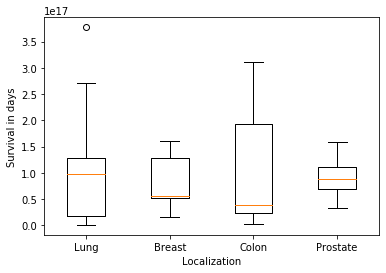

In [15]:
#boxplot
plt.boxplot([meta[meta['Localization']=='Lung']['Survival in days'],meta[meta['Localization']=='Breast']['Survival in days'],meta[meta['Localization']=='Colon']['Survival in days'],meta[meta['Localization']=='Prostate']['Survival in days']],labels = ['Lung','Breast','Colon','Prostate'])
plt.ylabel('Survival in days')
plt.xlabel('Localization');

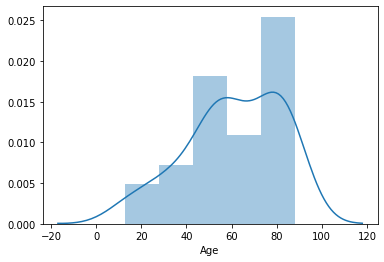

In [16]:
# histogram of age
sns.distplot(meta['Age']);

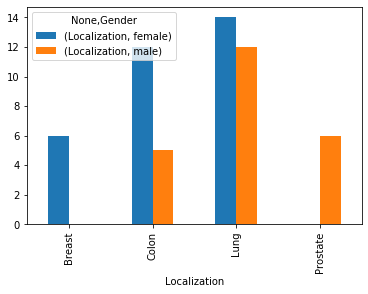

In [17]:
# number of diseases in the various  localizations of male/female patients
to_plot = meta.groupby(['Gender','Localization'])[['Localization']].count()
to_plot=to_plot.unstack(level=0)
to_plot.plot(kind='bar');